In [180]:
import pandas as pd
from statsmodels.multivariate.pca import PCA
import dcor
import seaborn as sns
import matplotlib.pyplot as plt
from bokeh.io import show, output_notebook
from bokeh.models import ColumnDataSource, HoverTool, Legend
from bokeh.palettes import Spectral6, Dark2, inferno
from bokeh.plotting import figure
from bokeh.transform import factor_cmap
from bokeh.models import Range1d
output_notebook()

Loading BokehJS ...

# Load data

In [210]:
df = pd.read_csv('../data/hnlog.csv')
df['vol'] = df['wt']*df['rep']
df = df.fillna(0).set_index(['ex', 'day', 'dt', 'wt', 'rep'])
df = df.multiply(df['vol'], axis='index').drop(columns=['group', 'vol'])

In [211]:
df = df.iloc[:, :]
df = df.groupby(['day', 'ex']).sum()

# Compare pairwise WOD `dCorr` values

In [212]:
cors = []
for i in range(df.index.max()[0]+1):
    for j in range(df.index.max()[0]+1):
        cor = dcor.distance_correlation(
            df.query(f'day=={i}').T, 
            df.query(f'day=={j}').T
        )
    
        cors.append([i, j, cor])

In [213]:
df_corr = pd.DataFrame(cors, columns=['day_A', 'day_B', 'corr'])
df_corr = df_corr.set_index(['day_A', 'day_B']).reset_index()
df_corr.pivot('day_A', 'day_B', 'corr')

day_B,0,1,2,3,4,5,6,7,8,9,10,11,12
day_A,,,,,,,,,,,,,
0,1.000000,0.574748,0.665191,0.0,0.186107,0.146951,0.654607,0.0,0.624724,0.145556,0.573734,0.0,0.779215
1,0.574748,1.000000,0.469417,0.0,0.208334,0.161679,0.450244,0.0,0.575774,0.158288,0.374509,0.0,0.436416
2,0.665191,0.469417,1.000000,0.0,0.199944,0.162036,0.981811,0.0,0.405171,0.163192,0.356129,0.0,0.778775
3,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000
4,0.186107,0.208334,0.199944,0.0,1.000000,0.478803,0.198870,0.0,0.188463,0.478858,0.136648,0.0,0.188132
5,0.146951,0.161679,0.162036,0.0,0.478803,1.000000,0.224042,0.0,0.140777,0.999941,0.105950,0.0,0.158129
6,0.654607,0.450244,0.981811,0.0,0.198870,0.224042,1.000000,0.0,0.394464,0.224688,0.399141,0.0,0.751528
7,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000
8,0.624724,0.575774,0.405171,0.0,0.188463,0.140777,0.394464,0.0,1.000000,0.142580,0.295638,0.0,0.549591


## Visualizing WOD Similarity

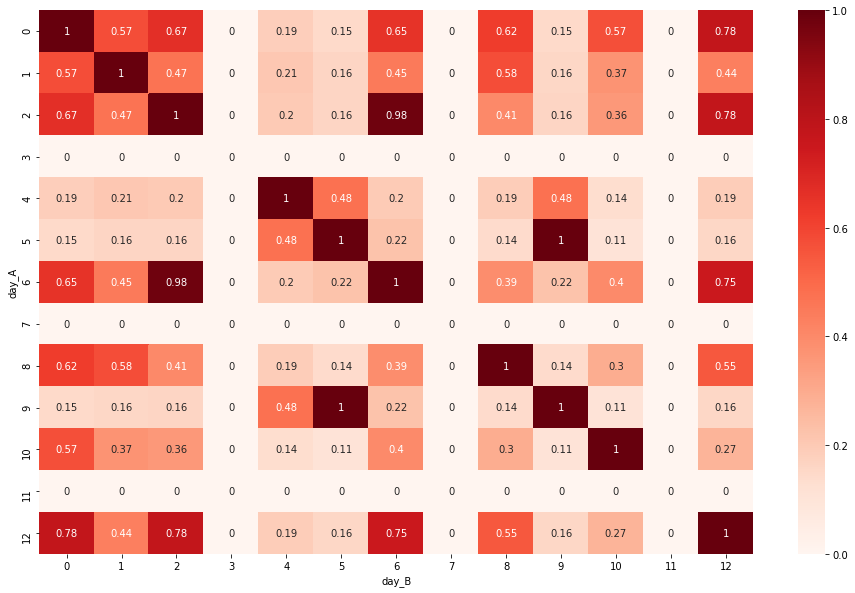

In [214]:
plt.figure(figsize=(16,10))
sns.heatmap(df_corr.pivot('day_A', 'day_B', 'corr'), cmap="Reds", annot=True);

### Interpreting the heatmap

The matrix above shows similarity among pairwise WODs. 1 being identical and 0 being least similar (or rest days). e.g. If we consider the bottom row, and read it from right to left, we see that day 12 has very little in common with day 8,9,10. But it is pretty close to day 5 & 6. Let's see if this makes intuitive sense or not by examining the WODs from those days...

In [191]:
df.query('day==12')

mmetcon   wtlft  bilateral  unilateral    push    pull  \
day ex                                                                       
12  deadlifts           0.0  7330.0     7330.0         0.0     0.0  7330.0   
    shoulder press      0.0  1065.0     1065.0         0.0  1065.0     0.0   

                    chest    back  shoulder   bi     tri    quad     ham  \
day ex                                                                     
12  deadlifts         0.0  7330.0       0.0  0.0     0.0  7330.0  7330.0   
    shoulder press    0.0     0.0    1065.0  0.0  1065.0     0.0     0.0   

                       hip  core  
day ex                            
12  deadlifts       7330.0   0.0  
    shoulder press     0.0   0.0

In [192]:
df.query('day==10')

mmetcon   wtlft  bilateral  unilateral  \
day ex                                                                        
10  arnold press                         0.0   600.0      600.0         0.0   
    bench press                          0.0  5400.0     5400.0         0.0   
    crossbody mountain climber           0.0     0.0        0.0       240.0   
    decline dumbbell bench press         0.0  1200.0     1200.0         0.0   
    decline stability ball push ups      0.0     0.0       40.0         0.0   
    eccentric handstand push ups         0.0     0.0       20.0         0.0   
    pike press                           0.0     0.0       20.0         0.0   
    six direction shoulder fly           0.0   250.0      250.0         0.0   
    stability ball push ups              0.0     0.0       40.0         0.0   
    stair climb                        201.0     0.0      201.0         0.0   

                                       push  pull   chest  back  shoulder  \
day ex                                                                      
10  arnold press                      600.0   0.0     0.0   0.0     600.0   
    bench press                      5400.0   0.0  5400.0   0.0       0.0   
    crossbody mountain climber          0.0   0.0     0.0   0.0       0.0   
    decline dumbbell bench press        0.0   0.0  1200.0   0.0    1200.0   
    decline stability ball push ups    40.0   0.0    40.0   0.0      40.0   
    eccentric handstand push ups       20.0   0.0     0.0   0.0      20.0   
    pike press                         20.0   0.0     0.0   0.0      20.0   
    six direction shoulder fly          0.0   0.0     0.0   0.0     250.0   
    stability ball push ups            40.0   0.0    40.0   0.0      40.0   
    stair climb                         0.0   0.0     0.0   0.0       0.0   

                                      bi     tri   quad    ham    hip   core  
day ex                                                                        
10  arnold press                     0.0     0.0    0.0    0.0    0.0    0.0  
    bench press                      0.0     0.0    0.0    0.0    0.0    0.0  
    crossbody mountain climber       0.0     0.0    0.0    0.0    0.0  240.0  
    decline dumbbell bench press     0.0  1200.0    0.0    0.0    0.0    0.0  
    decline stability ball push ups  0.0    40.0    0.0    0.0    0.0    0.0  
    eccentric handstand push ups     0.0    20.0    0.0    0.0    0.0    0.0  
    pike press                       0.0     0.0    0.0    0.0    0.0    0.0  
    six direction shoulder fly       0.0     0.0    0.0    0.0    0.0    0.0  
    stability ball push ups          0.0    40.0    0.0    0.0    0.0    0.0  
    stair climb                      0.0     0.0  201.0  201.0  201.0    0.0

In [193]:
df.query('day==5')

mmetcon    wtlft  bilateral  unilateral  push  \
day ex                                                                        
5   barbell floor press           0.0   8100.0     8100.0         0.0   0.0   
    deadlifts                     0.0  13500.0    13500.0         0.0   0.0   
    hollow body rocks             0.0      0.0       60.0         0.0   0.0   
    single arm KB OHS             0.0   2100.0        0.0      2100.0   0.0   
    squat jumps                   0.0      0.0       90.0         0.0   0.0   
    strict supinated pull up      0.0      0.0       30.0         0.0   0.0   

                                 pull   chest     back  shoulder   bi     tri  \
day ex                                                                          
5   barbell floor press           0.0  8100.0      0.0       0.0  0.0  8100.0   
    deadlifts                 13500.0     0.0  13500.0       0.0  0.0     0.0   
    hollow body rocks             0.0     0.0      0.0       0.0  0.0     0.0   
    single arm KB OHS             0.0     0.0      0.0    2100.0  0.0     0.0   
    squat jumps                   0.0     0.0      0.0       0.0  0.0     0.0   
    strict supinated pull up     30.0     0.0     30.0       0.0  0.0     0.0   

                                 quad      ham      hip  core  
day ex                                                         
5   barbell floor press           0.0      0.0      0.0   0.0  
    deadlifts                 13500.0  13500.0  13500.0   0.0  
    hollow body rocks             0.0      0.0      0.0  60.0  
    single arm KB OHS          2100.0   2100.0   2100.0   0.0  
    squat jumps                  90.0     90.0     90.0   0.0  
    strict supinated pull up      0.0      0.0      0.0   0.0

## Comparing multiple WODs

We can also compare workout from one day to multiple other days. Or one week to another week.

In [202]:
# comparing day 12 against days 0,1,2,4,5,6
dcor.distance_correlation(
    df.query(f'day in (0,1,2,4,5,6)').T, 
    df.query(f'day in (12,)').T
)

0.9568530722287787

In [204]:
dcor.distance_correlation(
    df.query(f'day in (0,1,2)').T, 
    df.query(f'day in (4,5,6)').T
)

0.933738631234019

In [205]:
dcor.distance_correlation(
    df.query(f'day in (0,1,2)').T, 
    df.query(f'day in (8,9,10)').T
)

0.713912609139641

In [206]:
dcor.distance_correlation(
    df.query(f'day in (4,5,6)').T, 
    df.query(f'day in (8,9,10)').T
)

0.73413129262813